# Evaluation

References for text similarity metrics: \
[BLEU Score](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b) -
[ROUGE Score](https://medium.com/@eren9677/text-summarization-387836c9e178) -
[NIST Score](https://aclanthology.org/www.mt-archive.info/HLT-2002-Doddington.pdf) -
[METEOR Score](https://aclanthology.org/W05-0909.pdf) -
[BERT Score](https://arxiv.org/pdf/1904.09675) -
[BLEURT Score](https://aclanthology.org/2020.acl-main.704.pdf)

[BLEURT installation](https://github.com/google-research/bleurt)

In [ ]:
#import os
#!git clone https://github.com/google-research/bleurt.git
#os.chdir('bleurt')
#!pip install .
#os.chdir('..')
#!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip .
#!unzip BLEURT-20.zip

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist
from rouge_score import rouge_scorer
import bert_score
from bleurt import score as bleurt_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import warnings
from pydantic import BaseModel, Field
from typing import Optional, TypedDict, Literal
from transformers import logging
from matplotlib.cm import get_cmap

#### Settings

In [2]:
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

In [3]:
data_folder = './data/'
result_folder = './results/'

In [4]:
debug_mode = False # set to True to test evaluation of stage 3

#### LLM

In [4]:
model_name = 'mistral'

In [5]:
#model_name = 'deepseek'

#### Classes to reload answers from Tree of Thoughts Graph

In [6]:
class HateClassification(BaseModel):
    hate_class: Literal['implicit_hate','not_hate']
    interpretations : Optional[str]
    explanation : Optional[str]
    confidence : Optional[float]
    recursion_level : int = 0

class ImplicitHateClassification(BaseModel):
    implicit_class_1: Literal['white_grievance', 'irony', 'stereotypical', 'incitement', 'other', 'threatening', 'inferiority', 'other']
    confidence_class_1: float
    explanation : str

class ImpliedMeaning(BaseModel):
    targeted_group: str
    implied_statement: str

In [7]:
def performance_comparison(df_result, title):
    
    df = df_result.set_index('Strategy').T
    
    #colors = ["#4C72B0", "#DD8452", "#55A868", "#8172B3"]  # Blue, Red, Green, Purple
    #colors = ["#003f5c", "#7a5195", "#ef5675", "#ffa600"]
    #colors = ["#4f81bd", "#c0504d", "#9bbb59", "#8064a2"]
    colors = ["#e7f2f8", "#74bdcb", "#ffa384", "#efe7bc"]
    #colors = ["#5e376d", "#bd97cb", "#f3eac0", "#747080"]    
    #colors = ["#c6dafc", "#7baaf7", "#4285f4", "#3367d6"]
    #colors = ["#177e89", "#084c61", "#db3a34", "#ffc857", "#323031"]
    
    #cmap = plt.get_cmap("tab20c")  # Try "viridis", "Set1", "coolwarm", etc.
    #colors = [cmap(i) for i in range(len(df.columns))]  # Assign colors to each metric
    

    # Plot the bar chart with custom colors and spacing
    ax = df.plot(kind="bar", width = 0.8, figsize=(8, 5), color=colors)
    
    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3, fontsize=8, color="black")
    
    # Customize the chart
    plt.title(title + "\n", fontsize=14, fontweight="bold")
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Metrics", fontsize=9, title_fontsize=10, loc="upper left", bbox_to_anchor=(0, 1))
    plt.grid(axis="y", linestyle="-", alpha=0.3)
    plt.savefig(result_folder + title + '.svg')
    # Show the plot
    plt.show()
    

# Evaluation Stage 1

In [8]:
test_file_stg1 = data_folder + "implicit_hate_test_stg1.csv"

In [9]:
def evaluate_stage_1(strategy, gold_file, pred_file):

    digits = 3
    
    df_gold = pd.read_csv(gold_file, encoding = 'utf-8')
    df_pred = pd.read_csv(pred_file, encoding = 'utf-8')

    label_selector = ['implicit_hate', 'not_hate' ]
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
    
    labels_gold = df_gold['class']
    predictions = df_pred['class']

    f1_macro = f1_score(labels_gold, predictions, average = "macro")
    accuracy = accuracy_score(labels_gold, predictions)
    precision = precision_score(labels_gold, predictions, average = "macro")
    recall = recall_score(labels_gold, predictions, average = "macro")
    
    clf_report = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector, digits = digits)
    clf_report_dict = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector,
                                            digits = digits, output_dict=True)
    clf_report_df = pd.DataFrame(clf_report_dict)
    
    values_export = clf_report_df.loc["f1-score", label_selector].T.values
    values_export = "\t".join([str(round(v,digits)) for v in values_export])
    
    report = f"""F1-macro: {str(round(f1_macro, digits))} accuracy: {str(round(accuracy, digits))} precision: {str(round(precision, digits))} recall: {str(round(recall, digits))} \n\n{clf_report}"""

    print('Hate classification - Strategy: ' + strategy + "\n\n" + report)    

    confusion_matrix = metrics.confusion_matrix(labels_gold, predictions,labels = label_selector)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_selector)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax )

    plt.show()

    return pd.DataFrame([{'Strategy' : strategy, "F1-macro" : f1_macro, 'Precision' : precision, 'Recall' : recall, 'Accuracy' : accuracy}])

    

### Baseline

Hate classification - Strategy: Baseline

F1-macro: 0.6 accuracy: 0.602 precision: 0.701 recall: 0.683 

               precision    recall  f1-score   support

implicit_hate      0.464     0.949     0.623      1036
     not_hate      0.939     0.417     0.578      1947

     accuracy                          0.602      2983
    macro avg      0.701     0.683     0.600      2983
 weighted avg      0.774     0.602     0.593      2983



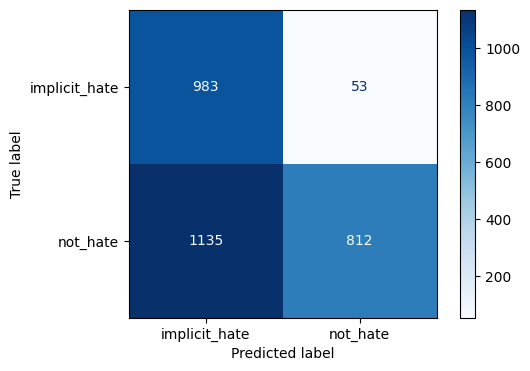

In [10]:
result_file_stg1 = result_folder + model_name + "_result_baseline_stg1.csv"
df_baseline_stg1 = evaluate_stage_1(
    'Baseline', 
    test_file_stg1, 
    result_file_stg1
)

### Prompt Tree of Thoughts

Hate classification - Strategy: Prompt ToT

F1-macro: 0.641 accuracy: 0.641 precision: 0.71 recall: 0.709 

               precision    recall  f1-score   support

implicit_hate      0.491     0.930     0.643      1034
     not_hate      0.930     0.488     0.640      1947

     accuracy                          0.641      2981
    macro avg      0.710     0.709     0.641      2981
 weighted avg      0.777     0.641     0.641      2981



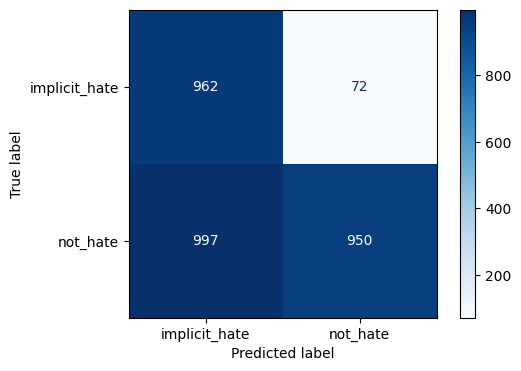

In [12]:
result_file_stg1 = result_folder + model_name + "_result_prompt_tot_stg1.csv"
df_prompt_tot_stg1 = evaluate_stage_1(
    "Prompt ToT",
    test_file_stg1, 
    result_file_stg1 
)

### Graph Tree of Thoughts

Hate classification - Strategy: Graph ToT

F1-macro: 0.676 accuracy: 0.676 precision: 0.719 recall: 0.73 

               precision    recall  f1-score   support

implicit_hate      0.519     0.908     0.661      1028
     not_hate      0.918     0.553     0.691      1934

     accuracy                          0.676      2962
    macro avg      0.719     0.730     0.676      2962
 weighted avg      0.780     0.676     0.680      2962



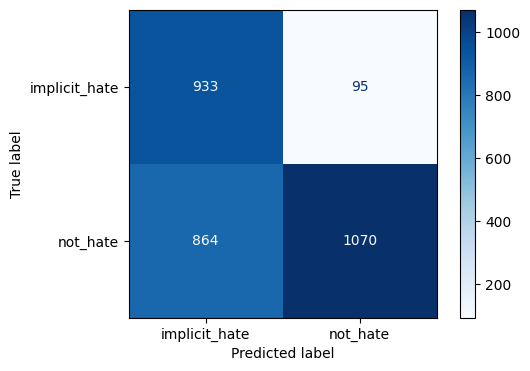

In [13]:
result_file_stg1 = result_folder + model_name + "_result_graph_stg1.csv"
df_graph_stg1 = evaluate_stage_1(
    "Graph ToT", 
    test_file_stg1, 
    result_file_stg1
)

### Optimizer MIPRO

Hate classification - Strategy: Optimized

F1-macro: 0.729 accuracy: 0.736 precision: 0.735 recall: 0.759 

               precision    recall  f1-score   support

implicit_hate      0.584     0.836     0.688      1045
     not_hate      0.886     0.682     0.771      1955

     accuracy                          0.736      3000
    macro avg      0.735     0.759     0.729      3000
 weighted avg      0.781     0.736     0.742      3000



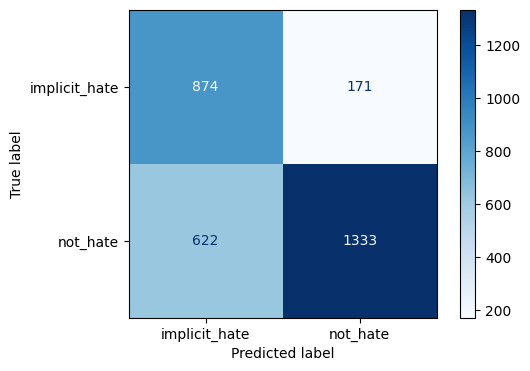

In [14]:
result_file_stg1 = result_folder + model_name + "_result_optimizer_stg1.csv"
df_optim_stg1 = evaluate_stage_1(
    "Optimized", 
    test_file_stg1, 
    result_file_stg1
)

## Results Stage 1

In [15]:
df_result_stg1 = pd.concat([df_baseline_stg1, df_prompt_tot_stg1, df_graph_stg1, df_optim_stg1])

In [20]:
df_result_stg1.to_excel(result_folder + model_name + '_evaluation_stg1.xlsx', index = False)

In [16]:
df_result_stg1 = pd.read_excel(result_folder + model_name + '_evaluation_stg1.xlsx')

In [17]:
df_result_stg1.head()

,Strategy,F1-macro,Precision,Recall,Accuracy
0,Baseline,0.600430,0.701423,0.682947,0.601743
1,Prompt ToT,0.641390,0.710308,0.709149,0.641396
2,Graph ToT,0.675538,0.718827,0.730423,0.676232
3,Optimized,0.729331,0.735264,0.759103,0.735667


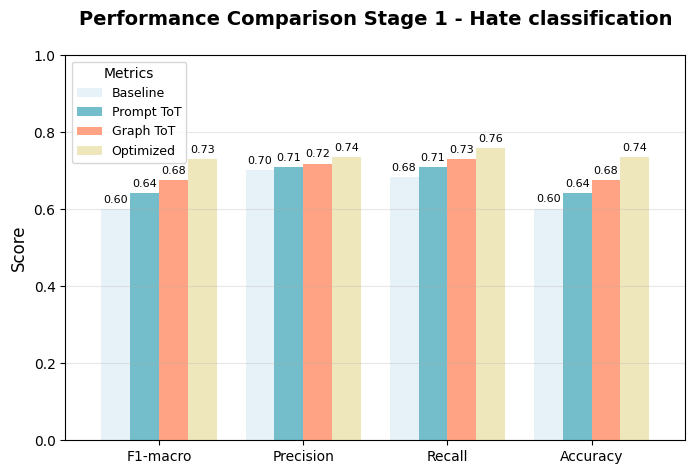

In [18]:
performance_comparison(df_result_stg1, 'Performance Comparison Stage 1 - Hate classification')

### Qualitative analysis (MIPRO results)

In [19]:
df_gold_stg1 = pd.read_csv(data_folder + "implicit_hate_test_stg1.csv", encoding = 'utf-8')
df_pred_stg1 = pd.read_csv(result_folder + model_name + "_result_optimizer_stg1.csv", encoding = 'utf-8')

#### Confidence

In [20]:
print(df_pred_stg1['confidence'].mean())

0.8368633333333334


In [21]:
df_pred_stg1.rename(columns={'class': 'class_pred'}, inplace=True)

In [22]:
df_pred_stg1.head()

,post_id,class_pred,confidence,explanation
0,8044,not_hate,0.90,The post is a neutral request for someone to w...
1,1709,not_hate,0.80,The post discusses political dynamics and does...
2,8898,not_hate,0.90,"The post is a general comment about ""fake news..."
3,6860,not_hate,0.90,The post is a factual statement about a legal ...
4,15379,implicit_hate,0.75,The post suggests that Hindus are suffering wh...


In [23]:
df_merge_stg1 = pd.merge(df_gold_stg1, df_pred_stg1, on = 'post_id')

In [24]:
df_merge_stg1.head()

,post_id,post,class,class_pred,confidence,explanation
0,8044,pl . watch odessa file on youtube and say sorr...,not_hate,not_hate,0.90,The post is a neutral request for someone to w...
1,1709,the left is losing their exalted status as def...,not_hate,not_hate,0.80,The post discusses political dynamics and does...
2,8898,more fake news,not_hate,not_hate,0.90,"The post is a general comment about ""fake news..."
3,6860,dr . goebbels ' estate sues publisher for prin...,not_hate,not_hate,0.90,The post is a factual statement about a legal ...
4,15379,poor hindus are suffering ; not kcr or owasis,not_hate,implicit_hate,0.75,The post suggests that Hindus are suffering wh...


#### Confidence of correct predictions

In [25]:
print(df_merge_stg1[df_merge_stg1['class'] == df_merge_stg1['class_pred']]['confidence'].mean())

0.8530539193475306


#### Confidence of wrong predictions

In [26]:
print(df_merge_stg1[df_merge_stg1['class'] != df_merge_stg1['class_pred']]['confidence'].mean())

0.7918032786885247


#### Examples of misclassified not hate posts with explanation

In [93]:
df_fp = df_merge_stg1[(df_merge_stg1['class'] == 'not_hate') & (df_merge_stg1['class_pred'] == 'implicit_hate')]

In [121]:
for idx, row in df_fp.sample(10).iterrows():
    print('\nPost: ' + str(row['post_id']) + ' - ' + row['post'])
    print('Confidence: ' + str(row['confidence']))
    print('Explanation: ' + row['explanation'])


Post: 15126 - fake news  black people would prefer immigration of white people but where do they originate from ? what's the origin of white people ?
Confidence: 0.75
Explanation: The post contains rhetorical questions that imply a divisive and potentially hateful narrative. The phrase "black people would prefer immigration of white people" suggests a stereotype or generalization about the preferences of black people, which could be seen as derogatory. Additionally, the questions about the origin of white people could be interpreted as a veiled attempt to promote a supremacist or divisive agenda. The confidence level is moderately high due to the implied racial undertones.

Post: 8769 - i have .. and have also read the crimes that zionist bankers inflicted on germans in weimar republic ..
Confidence: 0.75
Explanation: The post refers to "Zionist bankers" in a negative context, which is often a dog whistle for anti-Semitic sentiments. By attributing crimes to this group, the post impli

#### Was deepening used?

In [33]:
df_resp = pd.DataFrame(columns = ['post', 'explanation', 'recursion_level'])
files = glob.glob(result_folder + '/responses/*.json')

for filename in files:
    try: 
        with open(filename, 'r') as f:
            text = f.read()
            obj = json.loads(text)
            hate = eval(obj['hate_class']['repr'])
            new_row = {
                'post': obj['post'], 
                'explanation' : hate.explanation, 
                'recursion_level' : hate.recursion_level
            }
            df_resp = pd.concat([df_resp, pd.DataFrame([new_row])])
    except:
        print(filename)


#### Deepening was never used :(

In [34]:
df_resp[df_resp['recursion_level'] > 1]

,post,explanation,recursion_level


# Evaluation Stage 2

In [30]:
test_file_stg2 = data_folder + "implicit_hate_test_stg2.csv"

In [31]:
def evaluate_stage_2(strategy, gold_file, pred_file):

    digits = 3
    
    df_gold = pd.read_csv(gold_file, encoding = "utf-8")
    df_pred = pd.read_csv(pred_file, encoding = "utf-8")
    
    label_selector = ['incitement', 'white_grievance', 'inferiority', 'stereotypical', 'irony', 'threatening', 'other']
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
        
    labels_gold = df_gold['implicit_class']
    predictions = df_pred['implicit_class']
    
    f1_macro = f1_score(labels_gold, predictions, average = "macro")
    accuracy = accuracy_score(labels_gold, predictions)
    precision = precision_score(labels_gold, predictions, average = "macro")
    recall = recall_score(labels_gold, predictions, average = "macro")
    
    clf_report = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector, digits = digits)
    clf_report_dict = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector,
                                            digits = digits, output_dict=True)
    clf_report_df = pd.DataFrame(clf_report_dict)
    
    values_export = clf_report_df.loc["f1-score", label_selector].T.values
    values_export = "\t".join([str(round(v, digits)) for v in values_export])
    
    report = f"""F1-macro: {str(round(f1_macro, digits))} accuracy: {str(round(accuracy, digits))} precision: {str(round(precision, digits))} recall: {str(round(recall, digits))} \n\n{clf_report}
    """
    print('Implicit hate classification - Strategy: ' + strategy + "\n\n" + report)
    #print(values_export)

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(labels_gold, predictions, labels = label_selector)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=label_selector, yticklabels=label_selector,
           #title='Implicit hate classification\n',
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "#274c81")
    #fig.tight_layout()
    plt.show()

    return pd.DataFrame([{'Strategy' : strategy, "F1-macro" : f1_macro, 'Precision' : precision, 'Recall' : recall, 'Accuracy' : accuracy}])


### Baseline

Implicit hate classification - Strategy: Baseline

F1-macro: 0.47 accuracy: 0.552 precision: 0.493 recall: 0.468 

                 precision    recall  f1-score   support

     incitement      0.508     0.346     0.412       179
white_grievance      0.596     0.705     0.646       224
    inferiority      0.514     0.623     0.563       122
  stereotypical      0.480     0.626     0.543       171
          irony      0.610     0.526     0.565       116
    threatening      0.746     0.449     0.561        98
          other      0.000     0.000     0.000        10

       accuracy                          0.552       920
      macro avg      0.493     0.468     0.470       920
   weighted avg      0.558     0.552     0.544       920

    


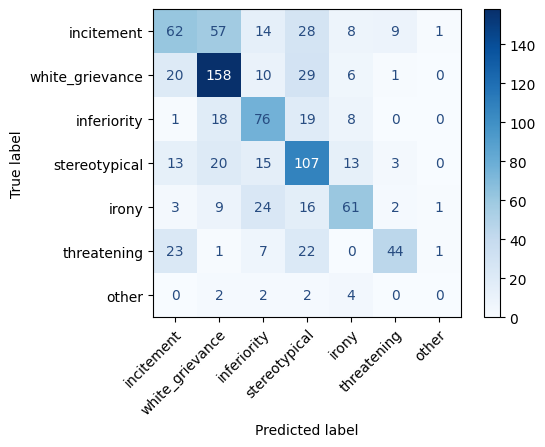

In [32]:
result_file_stg2 = result_folder + model_name + "_result_baseline_stg2.csv"
df_baseline_stg2 = evaluate_stage_2(
    "Baseline",
    test_file_stg2,
    result_file_stg2
)

### Prompt Tree of Thoughts

Implicit hate classification - Strategy: Prompt ToT

F1-macro: 0.408 accuracy: 0.492 precision: 0.418 recall: 0.419 

                 precision    recall  f1-score   support

     incitement      0.481     0.215     0.298       181
white_grievance      0.557     0.739     0.635       226
    inferiority      0.475     0.541     0.506       122
  stereotypical      0.430     0.450     0.440       171
          irony      0.446     0.500     0.472       116
    threatening      0.533     0.485     0.508        99
          other      0.000     0.000     0.000        10

       accuracy                          0.492       925
      macro avg      0.418     0.419     0.408       925
   weighted avg      0.485     0.492     0.475       925

    


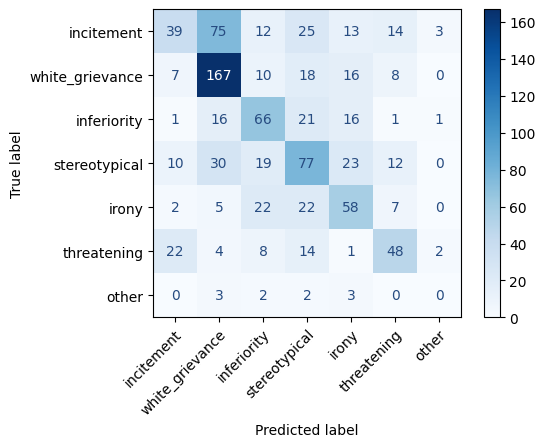

In [33]:
result_file_stg2 = result_folder + model_name + "_result_prompt_tot_stg2.csv"
df_prompt_tot_stg2 = evaluate_stage_2(
    "Prompt ToT",
    test_file_stg2,
    result_file_stg2
)

### Graph Tree of Thoughts

Implicit hate classification - Strategy: Graph ToT

F1-macro: 0.367 accuracy: 0.448 precision: 0.424 recall: 0.382 

                 precision    recall  f1-score   support

     incitement      0.371     0.264     0.308       163
white_grievance      0.784     0.377     0.510       212
    inferiority      0.365     0.639     0.465       108
  stereotypical      0.414     0.807     0.547       161
          irony      0.378     0.277     0.320       101
    threatening      0.659     0.310     0.422        87
          other      0.000     0.000     0.000        10

       accuracy                          0.448       842
      macro avg      0.424     0.382     0.367       842
   weighted avg      0.509     0.448     0.434       842

    


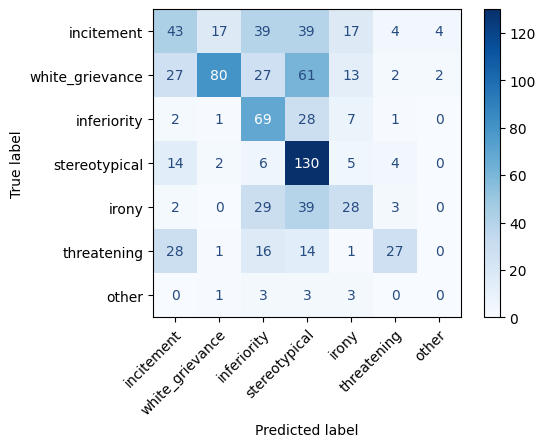

In [34]:
result_file_stg2 = result_folder + model_name + "_result_graph_stg2.csv"
df_graph_stg2 = evaluate_stage_2(
    "Graph ToT",
    test_file_stg2,
    result_file_stg2
)

### Optimizer MIPRO

Implicit hate classification - Strategy: Optimized

F1-macro: 0.516 accuracy: 0.581 precision: 0.558 recall: 0.51 

                 precision    recall  f1-score   support

     incitement      0.769     0.387     0.515       181
white_grievance      0.619     0.783     0.691       226
    inferiority      0.606     0.492     0.543       122
  stereotypical      0.592     0.585     0.588       171
          irony      0.600     0.466     0.524       116
    threatening      0.708     0.758     0.732        99
          other      0.012     0.100     0.021        10

       accuracy                          0.581       925
      macro avg      0.558     0.510     0.516       925
   weighted avg      0.642     0.581     0.594       925

    


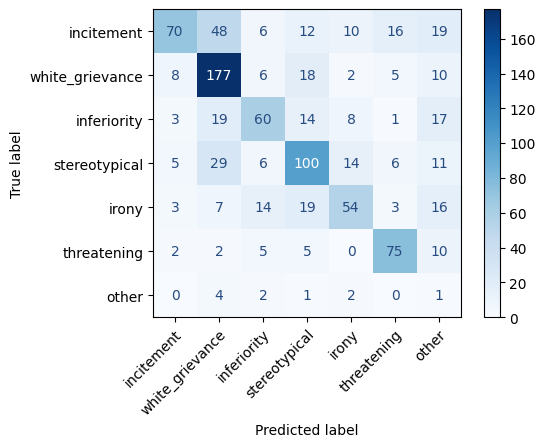

In [35]:
result_file_stg2 = result_folder + model_name + "_result_optimizer_stg2.csv"
df_optim_stg2 = evaluate_stage_2(
    "Optimized",
    test_file_stg2,
    result_file_stg2
)

## Final results Stage 2

In [36]:
df_result_stg2 = pd.concat([df_baseline_stg2, df_prompt_tot_stg2, df_graph_stg2, df_optim_stg2])

In [42]:
df_result_stg2.to_excel(result_folder +  model_name + '_evaluation_stg2.xlsx', index = False)

In [37]:
df_result_stg2 = pd.read_excel(result_folder + model_name + '_evaluation_stg2.xlsx')

In [38]:
df_result_stg2.head()

,Strategy,F1-macro,Precision,Recall,Accuracy
0,Baseline,0.469944,0.493360,0.467893,0.552174
1,Prompt ToT,0.408274,0.417518,0.418647,0.491892
2,Graph ToT,0.367384,0.424430,0.382154,0.447743
3,Optimized,0.516370,0.557906,0.509945,0.580541


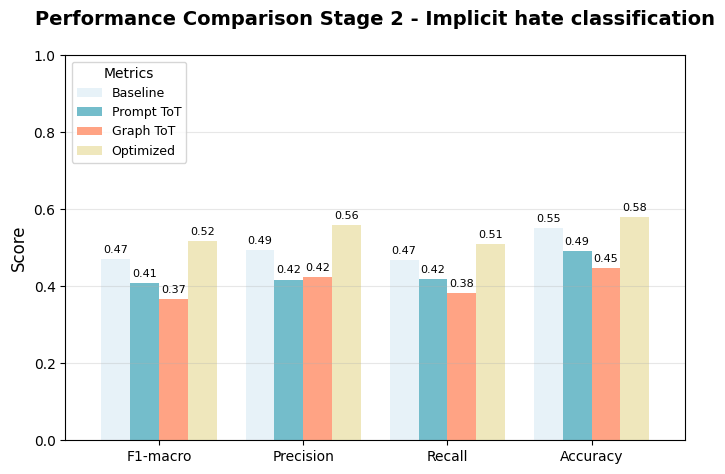

In [40]:
performance_comparison(df_result_stg2, 'Performance Comparison Stage 2 - Implicit hate classification')

### Qualitative analysis (results of MIPRO optimizer)

In [41]:
df_gold_stg2 = pd.read_csv(data_folder + "implicit_hate_test_stg2.csv", encoding = 'utf-8')
df_pred_stg2 = pd.read_csv(result_folder + model_name + "_result_optimizer_stg2.csv", encoding = 'utf-8')

#### Overall confidence

In [42]:
print(df_pred_stg2['confidence'].mean())

0.8525729729729729


In [43]:
df_pred_stg2.rename(columns={'implicit_class': 'implicit_class_pred'}, inplace=True)

In [44]:
df_pred_stg2.head()

,post_id,implicit_class_pred,confidence,explanation
0,9275,stereotypical,0.90,The post perpetuates negative stereotypes abou...
1,1006,white_grievance,0.85,"The post discusses a ""white privilege tax"" sup..."
2,20335,inferiority,0.75,"The post uses the derogatory term ""hermangutie..."
3,1173,white_grievance,0.90,The post expresses frustration and resentment ...
4,4917,stereotypical,0.90,The post perpetuates negative stereotypes abou...


In [45]:
df_merge_stg2 = pd.merge(df_gold_stg2, df_pred_stg2, on = 'post_id')

In [46]:
df_merge_stg2.head()

,post_id,post,implicit_class,implicit_class_pred,confidence,explanation
0,9275,""" : racist black thugs shoot white baby in t...",stereotypical,stereotypical,0.90,The post perpetuates negative stereotypes abou...
1,1006,"new "" white privilege tax "" "" for all white ...",white_grievance,white_grievance,0.85,"The post discusses a ""white privilege tax"" sup..."
2,20335,"if you even pay taxes, hermangutierr.",stereotypical,inferiority,0.75,"The post uses the derogatory term ""hermangutie..."
3,1173,agree . i'm sick of these self-hating behavior...,white_grievance,white_grievance,0.90,The post expresses frustration and resentment ...
4,4917,blacks have the best party time in white count...,stereotypical,stereotypical,0.90,The post perpetuates negative stereotypes abou...


#### Confidence of correct predictions

In [47]:
print(df_merge_stg2[df_merge_stg2['implicit_class'] == df_merge_stg2['implicit_class']]['confidence'].mean())

0.8525729729729729


#### Confidence of wrong predictions

In [48]:
print(df_merge_stg2[df_merge_stg2['implicit_class'] != df_merge_stg2['implicit_class_pred']]['confidence'].mean())

0.833840206185567


#### Examples of misclassified posts

In [49]:
df_errors = df_merge_stg2[df_merge_stg2['implicit_class'] != df_merge_stg2['implicit_class_pred']]

In [50]:
# Misclassified incitement
df_errors = df_merge_stg2[(df_merge_stg2['implicit_class'] =='incitement') & (df_merge_stg2['implicit_class_pred'] =='white_grievance')]

In [51]:
for idx, row in df_errors.sample(10).iterrows():
    print('\nPost: ' + str(row['post_id']) + ' - ' + row['post'])
    print('Gold class: ' + row['implicit_class'] +' - Pred class: ' + row['implicit_class_pred'] +' - Confidence: ' + str(row['confidence']) )
    print('Explanation: ' + row['explanation'])


Post: 8576 - are you talking about the same white supremacists who saved your people from genicide ?
Gold class: incitement - Pred class: white_grievance - Confidence: 0.85
Explanation: The post defends white supremacists by claiming they saved a group from genocide, suggesting a sense of grievance and victimhood. This aligns with the "white grievance" category, which includes frustration over perceived privileges of minority groups and the idea that majority groups are the real victims of racism. The confidence level is 0.85 as the post clearly expresses a grievance related to white supremacists but leaves some room for interpretation.

Post: 19105 - you mean the constitution written by white people for white people ? those conservatives would deny that !
Gold class: incitement - Pred class: white_grievance - Confidence: 0.8
Explanation: The post suggests that the U.S. Constitution was written by and for white people, implying a sense of white ownership and grievance. This fits the "

# Evaluation Stage 3

Initialize BLEURT Scorer

In [ ]:
checkpoint =  "BLEURT-20"
bleurt_scorer = bleurt_score.BleurtScorer(checkpoint)

In [ ]:
result_file_stg3 = data_folder + 'implicit_hate_test_stg3.csv'

### Text similarity metrics

In [ ]:
def compute_similarity_metrics(generated, reference, bleurt_scorer, bert_lang='en'):

    generated_tokens = nltk.word_tokenize(generated.lower())
    reference_tokens = nltk.word_tokenize(reference.lower())

    # Compute BLEU Score

    # Smoothing method1: adds 1 to the numerator and denominator for higher-order n-grams with no matches, akin to additive smoothing.
    # Works well for very short sentences or cases with few matches.
    smoothing = SmoothingFunction().method1

    bleu = sentence_bleu([reference_tokens], generated_tokens, smoothing_function = smoothing)
    bleu_1 = sentence_bleu([reference_tokens], generated_tokens, weights=(1, 0, 0, 0), smoothing_function = smoothing)
    bleu_2 = sentence_bleu([reference_tokens], generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function = smoothing) # Cumulative

    # Compute ROUGE Score (F1)
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge_scorer_obj.score(reference, generated)
    rouge_f1 = {
        'ROUGE-1': rouge_scores['rouge1'].fmeasure,
        'ROUGE-2': rouge_scores['rouge2'].fmeasure,
        'ROUGE-L': rouge_scores['rougeL'].fmeasure
    }
    # Compute METEOR Score
    meteor = meteor_score([reference_tokens], generated_tokens)

    # Compute NIST Score
    n = np.min((len(reference_tokens),len(generated_tokens),2))
    nist = sentence_nist([reference_tokens], generated_tokens, n = n)

    # Compute BERTScore (F1)
    P, R, F1 = bert_score.score([generated], [reference], lang=bert_lang, verbose=False)
    bert_f1 = F1.mean().item()

    # Compute BLUERT score
    bleurt_scores = bleurt_scorer.score(references = [reference], candidates = [generated])
    if isinstance(bleurt_scores, list) and len(bleurt_scores) == 1:
        bleurt = bleurt_scores[0]
    else:
        0

    # Combine scores
    return {
        'BLEU-1' : bleu_1,
        'BLEU-2' : bleu_2,
        'BLEU': bleu,
        **rouge_f1,
        'METEOR' : meteor,
        'NIST' : nist,
        'BERTScore': bert_f1,
        'BLEURTScore' : bleurt
    }
    

## Target similarity

In [ ]:
def compute_target_similarity(strategy, gold_file, pred_file, bleurt_scorer, debug_mode = False):

    df_gold = pd.read_csv(gold_file, encoding="utf-8")
    df_pred = pd.read_csv(pred_file, encoding="utf-8")    
    
    df_pred = df_pred[df_pred['target'].notnull()]
    df_pred = df_pred[df_pred['target'].notna()] 
    
    if debug_mode:
        df_pred = df_pred.sample(2)
    
    df_gold.rename(columns={'target': 'target_gold'}, inplace=True)
    df_pred.rename(columns={'target': 'target_pred'}, inplace=True)
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
    
    df_merge = pd.merge(df_gold, df_pred, on = "post_id")
    df_target = df_merge[['post_id', 'post', 'target_gold', 'target_pred']]
    
    # Compute metrics
    similarity_metrics = df_target.apply(lambda row: compute_similarity_metrics(row['target_pred'], row['target_gold'], bleurt_scorer), axis=1)
    
    # Flatten the metrics into separate columns
    metrics_df = pd.DataFrame(similarity_metrics.tolist())
    
    # Combine the original DataFrame with the metrics
    df_target_result = pd.concat([df_target, metrics_df], axis=1)
    df_target_result_max = df_target_result.groupby('post_id')[df_target_result.columns[4: ].tolist()].max()
    
    # Average results
    df_result = df_target_result_max[1: ].mean().to_frame().T
    df_result.insert(loc = 0, column = 'Strategy', value = strategy)
    
    return df_result

### Baseline

In [ ]:
target_similiarty_baseline = compute_target_similarity(
    'Baseline',
    result_file_stg3,
    result_folder + model_name + '_result_baseline_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Prompt Tree of Thoughts

In [ ]:
target_similiarty_prompt_tot = compute_target_similarity(
    'Prompt ToT',
    result_file_stg3,
    result_folder + model_name + '_result_prompt_tot_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Graph Tree of Thoughts

In [ ]:
target_similiarty_graph = compute_target_similarity(
    'Graph ToT',
    result_file_stg3,
    result_folder + model_name + '_result_graph_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Otimizer MIPRO

In [ ]:
target_similiarty_optimized = compute_target_similarity(
    'Optimized',
    result_file_stg3,
    result_folder + model_name + '_result_optimizer_stg3.csv',
    bleurt_scorer,
    debug_mode
)

## Result Target similarity

In [ ]:
target_similarity_result = pd.concat(
    [target_similiarty_baseline, 
     target_similiarty_prompt_tot, 
     target_similiarty_graph, 
     target_similiarty_optimized]
)

In [ ]:
if debug_mode == False:
    target_similarity_result.to_excel(result_folder + model_name + '_evaluation_stg3_target.xlsx', index = False)

In [57]:
target_similarity_result = pd.read_excel(result_folder + model_name + '_evaluation_stg3_target.xlsx')

Rename columns for paper

In [58]:
target_similarity_result.rename(columns={
    'BLEU-1' : 'B1',
    'BLEU-2' : 'B2',	
    'BLEU' : 'B',
    'ROUGE-1' : 'R1',
    'ROUGE-2' : 'R2',
    'ROUGE-L' : 'R-L',
    'NIST' : 'NI',
    'METEOR' : 'M',
    'BERTScore': 'BS', 
    'BLEURTScore': 'BL'}, 
    inplace = True)

In [59]:
target_similarity_result.head()

,Strategy,B1,B2,B,R1,R2,R-L,M,NI,BS,BL
0,Baseline,0.557766,0.263994,0.126302,0.648212,0.168741,0.647696,0.365063,0.206672,0.946971,0.599681
1,Prompt ToT,0.513928,0.254331,0.120395,0.598005,0.161642,0.597419,0.353700,0.201583,0.938466,0.553218
2,Graph ToT,0.493070,0.234434,0.113799,0.592984,0.142689,0.592356,0.342325,0.180346,0.934934,0.553094
3,Optimized,0.599613,0.327923,0.142451,0.682189,0.252921,0.681914,0.416488,0.263856,0.953460,0.593098


In [60]:
target_similarity_result.to_excel(result_folder + model_name + '_evaluation_stg3_target_paper.xlsx', index = False)

## Meaning similarity

In [ ]:
def compute_meaning_similarity(strategy, gold_file, pred_file, bleurt_scorer, debug_mode = False):

    df_gold = pd.read_csv(gold_file, encoding="utf-8")
    df_pred = pd.read_csv(pred_file, encoding="utf-8")

    df_pred = df_pred[df_pred['implied_statement'].notnull()]
    df_pred = df_pred[df_pred['implied_statement'].notna()]    
    
    if debug_mode:
        df_pred = df_pred.sample(2)
        
    df_gold.rename(columns={'implied_statement': 'implied_statement_gold'}, inplace=True)
    df_pred.rename(columns={'implied_statement': 'implied_statement_pred'}, inplace=True)
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
    
    df_merge = pd.merge(df_gold, df_pred, on = "post_id")
    df_meaning = df_merge[['post_id', 'post', 'implied_statement_gold', 'implied_statement_pred']]
    
    # Compute metrics
    similarity_metrics = df_meaning.apply(lambda row: compute_similarity_metrics(row['implied_statement_pred'], row['implied_statement_gold'], bleurt_scorer), axis=1)
    
    # Flatten the metrics into separate columns
    metrics_df = pd.DataFrame(similarity_metrics.tolist())
    
    # Combine the original DataFrame with the metrics
    df_meaning_result = pd.concat([df_meaning, metrics_df], axis=1)
    df_meaning_result_max = df_meaning_result.groupby('post_id')[df_meaning_result.columns[4: ].tolist()].max()
    
    # Average results
    df_result = df_meaning_result_max[1: ].mean().to_frame().T
    df_result.insert(loc = 0, column = 'Strategy', value = strategy)

    return df_result
    

### Baseline

In [ ]:
meaning_similiarty_baseline = compute_meaning_similarity(
    'Baseline',
    result_file_stg3,
    result_folder + model_name + '_result_baseline_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Prompt Tree of Thoughts

In [ ]:
meaning_similiarty_prompt_tot = compute_meaning_similarity(
    'Prompt ToT',
    result_file_stg3,
    result_folder +  model_name + '_result_prompt_tot_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Graph Tree of Thoughts

In [ ]:
meaning_similiarty_graph = compute_meaning_similarity(
    'Graph ToT',
    result_file_stg3,
    result_folder + model_name + '_result_graph_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Optimizer MIPRO

In [ ]:
meaning_similiarty_optimized = compute_meaning_similarity(
    'Optimized',
    result_file_stg3,
    result_folder + model_name + '_result_optimizer_stg3.csv',
    bleurt_scorer,
    debug_mode
)

## Results Meaning similarity

In [ ]:
meaning_similarity_result = pd.concat(
    [meaning_similiarty_baseline,
     meaning_similiarty_prompt_tot, 
     meaning_similiarty_graph, 
     meaning_similiarty_optimized]
)

In [ ]:
if debug_mode == False:
    meaning_similarity_result.to_excel(result_folder + model_name + '_evaluation_stg3_meaning.xlsx', index = False)

In [61]:
meaning_similarity_result = pd.read_excel(result_folder + model_name + '_evaluation_stg3_meaning.xlsx')

Rename columns for paper

In [63]:
meaning_similarity_result.rename(columns={
    'BLEU-1' : 'B1',
    'BLEU-2' : 'B2',	
    'BLEU' : 'B',
    'ROUGE-1' : 'R1',
    'ROUGE-2' : 'R2',
    'ROUGE-L' : 'R-L',
    'NIST' : 'NI',
    'METEOR' : 'M',
    'BERTScore': 'BS', 
    'BLEURTScore': 'BL'
    }, 
    inplace = True)

In [64]:
meaning_similarity_result.head()

,Strategy,B1,B2,B,R1,R2,R-L,M,NI,BS,BL
0,Baseline,0.312300,0.201347,0.110530,0.425311,0.190307,0.413189,0.308253,0.651363,0.913536,0.486281
1,Prompt ToT,0.276235,0.169873,0.084185,0.376240,0.158266,0.364460,0.303698,0.608512,0.904943,0.467554
2,Graph ToT,0.271485,0.167285,0.082901,0.376487,0.154722,0.363244,0.296526,0.592457,0.905518,0.473427
3,Optimized,0.410091,0.286418,0.163701,0.501659,0.302799,0.489305,0.420038,0.895411,0.924709,0.521215


In [65]:
meaning_similarity_result.to_excel(result_folder + model_name + '_evaluation_stg3_meaning_paper.xlsx', index = False)

### Qualitative analysis (target, MIPRO results)

In [52]:
df_gold_stg3 = pd.read_csv(data_folder + "implicit_hate_test_stg3.csv", encoding = 'utf-8')
df_pred_stg3 = pd.read_csv(result_folder + model_name + "_result_optimizer_stg3.csv", encoding = 'utf-8')

In [53]:
df_gold_stg3['target'] = df_gold_stg3['target'].str.lower()
df_pred_stg3['target'] = df_pred_stg3['target'].str.lower()

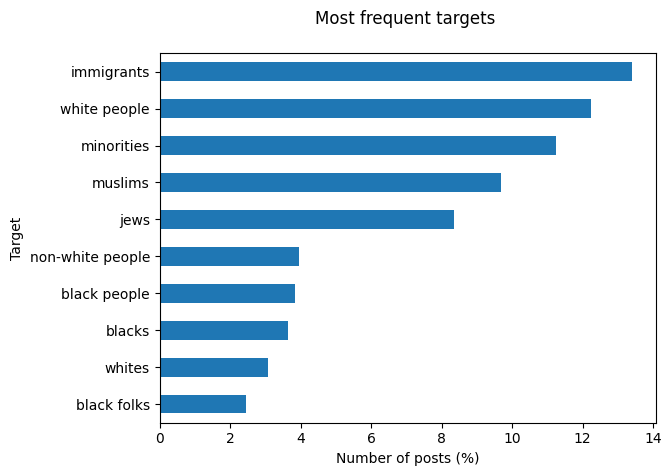

In [54]:
p = df_gold_stg3.groupby(['target'])['post_id'].count().div(len(df_gold_stg3)).multiply(100).sort_values().tail(10).plot(
    kind = 'barh', 
    xlabel='Number of posts (%)', 
    ylabel = 'Target',  
    title = 'Most frequent targets \n'
)                                                                               

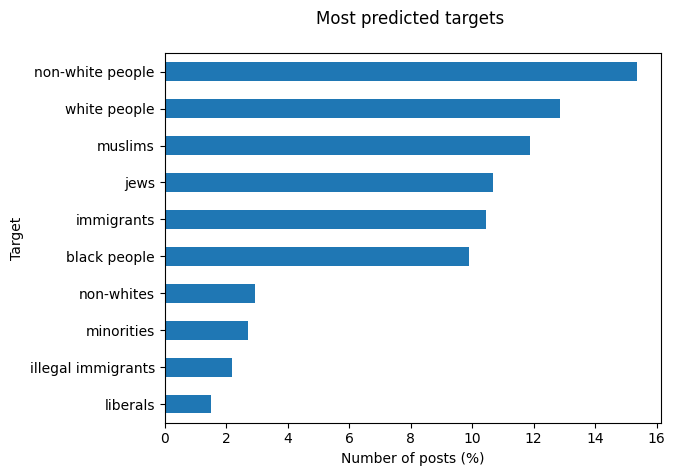

In [55]:
p = df_pred_stg3.groupby(['target'])['post_id'].count().div(len(df_pred_stg3)).multiply(100).sort_values().tail(10).plot(
    kind = 'barh', 
    xlabel='Number of posts (%)', 
    ylabel = 'Target',  
    title = 'Most predicted targets \n'
)

#### Immigrants

In [56]:
df_immigrants = df_gold_stg3[df_gold_stg3['target'] == 'immigrants']

In [57]:
df_pred_immigrants = df_pred_stg3[df_pred_stg3['post_id'].isin(df_immigrants['post_id'])]
df_pred_immigrants = df_pred_immigrants[df_pred_immigrants['target'] != 'immigrants']

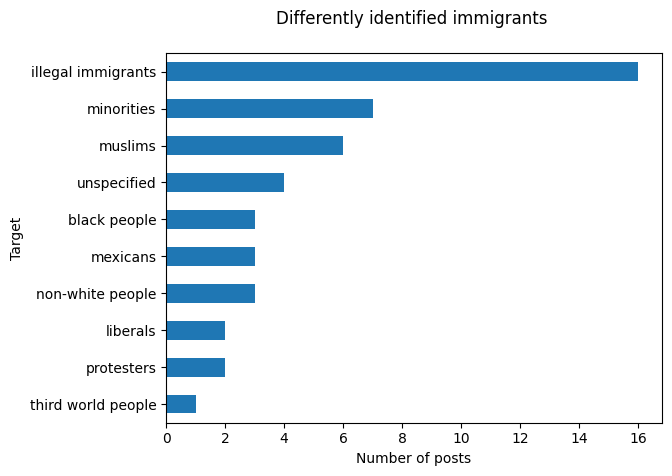

In [58]:
p = df_pred_immigrants.groupby(['target'])['post_id'].count().sort_values().tail(10).plot(
    kind = 'barh', 
    xlabel='Number of posts', 
    ylabel = 'Target',  
    title = 'Differently identified immigrants \n'
) 

In [59]:
df_pred_immigrants[df_pred_immigrants['target'] != 'immigrants'].sample(10)

,post_id,target,implied_statement
160,20739,illegal immigrants,Illegal immigrants should be targeted.
864,14451,illegal aliens,Illegal aliens are criminals.
822,19837,minorities,Minorities are not good at math.
27,5711,third world people,Third world people are unintelligent.
11,19941,religious or cultural group,Religious or cultural group is desperate and f...
599,20255,unspecified,Unspecified group should be eliminated
279,19921,non-indian migrants,"non-Indian migrants are not family-focused, ha..."
600,20219,illegal immigrants,Illegal Immigrants are exploitative.
683,19699,poor people,Poor people are violent.
452,14597,non-white people,non-white people are unwanted


In [81]:
df_merge_stg3 = pd.merge(df_gold_stg3, df_pred_stg3.rename(columns={'target': 'target_pred', 'implied_statement': 'implied_statement_pred'}), on = 'post_id')

In [82]:
df_whites = df_merge_stg3[(df_merge_stg3['target'] == 'white people') & (df_merge_stg3['target_pred'] == 'black people')]

In [87]:
for idx, row in df_whites.sample(10).iterrows():
    print('\nPost: ' + str(row['post_id']) + ' - ' + row['post'])
    #print('Gold target: ' + row['target'] +' - Pred target: ' + row['target_pred'])
    print('Implied statement gold: ' + row['implied_statement'])
    print('Implied statement pred: ' + row['implied_statement_pred'])


Post: 3372 - maybe you should build your thriving black communities far away where white people can't get to them
Implied statement gold: White people try to take over black communities
Implied statement pred: Black people are harmful.

Post: 12077 -  new video :  " madness at #mizzou : black hysteria and white cowardice " " #tcot #altright "
Implied statement gold: White people are scared of blacks.
Implied statement pred: Black people are irrational.

Post: 14800 -   " american " " means nothing . whites need to start looking out for themselves . u want " " america " " to end up like south africa ? "
Implied statement gold: White people need to stick together.
Implied statement pred: Black people are a threat to whites.

Post: 456 - i have an ultra liberal next door who says there is no such thing as black racist only white people can be racist unbelievable
Implied statement gold: White people are racist.
Implied statement pred: Black people are racist.

Post: 13488 - no  white wome

#### Example of post correctly classified by Tree of Thought Graph

In [62]:
correct_stg1 = df_merge_stg1[df_merge_stg1['class'] == df_merge_stg1['class_pred']]['post_id'].to_list()

In [63]:
correct_stg2 = df_merge_stg2[df_merge_stg2['implicit_class'] == df_merge_stg2['implicit_class_pred']]['post_id'].to_list()

In [64]:
correct_stg3 =df_merge_stg3[df_merge_stg3['target'] == df_merge_stg3['target_pred']]['post_id'].to_list()

In [65]:
correct = list(set(correct_stg1) & set(correct_stg2) & set(correct_stg3))

In [66]:
len(correct)

240

In [67]:
correct[0]

19457

In [68]:
line_sep = '\n' + '-' * 100

In [69]:
filename = result_folder + '/responses/mistral_19457.json'
with open(filename, 'r') as f:
    text = f.read()
    obj = json.loads(text)
    hate = eval(obj['hate_class']['repr'])

print(line_sep)
print('Post\n\n' + obj['post'])
print(line_sep)
print('Abuse subtypes\n\n' + obj['abuse_subtypes']['kwargs']['content'])
print(line_sep)
print('World knowledge\n\n' + obj['world_knowledge']['kwargs']['content'])
print(line_sep)
print('Generate interpretations\n\n' + obj['interpretations']['kwargs']['content'])
print(line_sep)
print('Evaluate interpretations\n')
hate = eval(obj['hate_class']['repr'])
print('Class: ' + hate.hate_class) 
print('Confidence: ' + str(hate.confidence))
print('Explanation: ' + hate.explanation) 
print(line_sep)
print('Classify implicit hate\n')
implicit_hate_class = eval(obj['implicit_hate_class']['repr'])
print('Implicit hate class: ' + implicit_hate_class.implicit_class_1)
print('Explanation: '+ implicit_hate_class.explanation)
print(line_sep)
print('Identify implied meaning\n')
implied_meaning = eval(obj['implied_meaning']['repr'])
print('Targeted group: ' + implied_meaning.targeted_group)
print('Implied statement: ' +implied_meaning.implied_statement)


----------------------------------------------------------------------------------------------------
Post

the best medicine for perverts is to ship to isil..they will take good care of u..

----------------------------------------------------------------------------------------------------
Abuse subtypes

The text contains implicit abusive language that falls under the subtype:

6. Call for Action: Statements urging actions, often harmful, against a group (e.g., "He should be given 5000 volts!").

The text suggests sending individuals labeled as "perverts" to ISIL, implying that they will be harmed or mistreated, which is a call for harmful action against a group.

----------------------------------------------------------------------------------------------------
World knowledge

The text falls under the category of "Other Implicit Abuse." The statement suggests that individuals deemed "perverts" should be sent to ISIL (another name for ISIS), implying that they will be severely pun

Data for PowerBI Sankey diagram

In [70]:
df_sankey = df_merge_stg3[df_merge_stg3['target'].isin(df_pred_stg3['target'].value_counts()[0:5].index.to_list())][['target','target_pred']]

In [71]:
df_sankey = df_sankey.groupby(['target','target_pred']).size().reset_index().rename(columns={0: 'count'})

In [226]:
df_sankey[df_sankey['count'] > 3].head()

,target,target_pred,count
8,immigrants,illegal immigrants,23
10,immigrants,immigrants,123
21,immigrants,mexicans,4
22,immigrants,minorities,10
23,immigrants,muslims,7


In [73]:
df_sankey.to_csv(result_folder + model_name + "_sankey_target.csv", index = False)